In [21]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Nov 11 09:06:56 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    53W / 400W |   9616MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [22]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!pip install MTCNN

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.3 MB 4.7 MB/s 


In [10]:
!unzip "/content/drive/MyDrive/Research/Cropped_FER_2013.zip"

Streaming output truncated to the last 5000 lines.
  inflating: Cropped_FER_2013/train/happy/Training_56979079.jpg  
  inflating: Cropped_FER_2013/train/happy/Training_93085773.jpg  
  inflating: Cropped_FER_2013/train/happy/Training_13072904.jpg  
  inflating: Cropped_FER_2013/train/happy/Training_87036309.jpg  
  inflating: Cropped_FER_2013/train/neutral/Training_36473538.jpg  
  inflating: Cropped_FER_2013/train/happy/Training_41427168.jpg  
  inflating: Cropped_FER_2013/train/happy/Training_68102525.jpg  
  inflating: Cropped_FER_2013/train/happy/Training_78137671.jpg  
  inflating: Cropped_FER_2013/train/happy/Training_29013082.jpg  
  inflating: Cropped_FER_2013/train/happy/Training_35699179.jpg  
  inflating: Cropped_FER_2013/train/happy/Training_52125145.jpg  
  inflating: Cropped_FER_2013/train/happy/Training_96395405.jpg  
  inflating: Cropped_FER_2013/train/sad/Training_47114528.jpg  
  inflating: Cropped_FER_2013/train/happy/Training_63340234.jpg  
  inflating: Cropped_FER_

In [12]:
!cp -r Cropped_FER_2013 "/content/drive/MyDrive/Research/"

In [6]:
pwd


'/content'

In [23]:
from mtcnn import MTCNN
import cv2
import os, glob
import numpy as np
# from tqdm import tqdm_notebook
from tqdm.notebook import tqdm_notebook
import shutil
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import keras
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [26]:
base_model = keras.applications.efficientnet.EfficientNetB7(
    weights = 'imagenet',  # Load weights pre-trained on ImageNet.
    input_shape = (224, 224, 3),
    include_top = False,
    classifier_activation = "softmax",
    classes = 7
) 

base_model.trainable = True

# inputs = keras.Input(shape=(224, 224, 3))
inputs = keras.Input(shape=(224, 224, 3))

x = base_model(inputs, training=True)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(7, activation="softmax")(x)

model = keras.Model(inputs, outputs)

In [27]:
path="/content/drive/MyDrive/Research/Cropped_FER_2013/train"

# dataset = keras.preprocessing.image_dataset_from_directory(path, image_size=(224, 224), label_mode="categorical")
train_dataset = keras.preprocessing.image_dataset_from_directory(path, image_size=(224, 224), label_mode="categorical", validation_split=0.3, subset="training", seed=42)
valid_dataset = keras.preprocessing.image_dataset_from_directory(path, image_size=(224, 224), label_mode="categorical", validation_split=0.3, subset="validation", seed=42)



Found 23380 files belonging to 7 classes.
Using 16366 files for training.
Found 23380 files belonging to 7 classes.
Using 7014 files for validation.


In [28]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss="categorical_crossentropy",
              metrics=["accuracy"])
# model.fit(dataset, epochs=20, validation_split=0.2)
history = model.fit(train_dataset, epochs=30, validation_data=valid_dataset)


Epoch 1/30
512/512 [==============================] - 475s 860ms/step - loss: 1.1931 - accuracy: 0.5571 - val_loss: 1.0450 - val_accuracy: 0.6079
Epoch 2/30
512/512 [==============================] - 436s 851ms/step - loss: 0.9828 - accuracy: 0.6402 - val_loss: 1.0101 - val_accuracy: 0.6255
Epoch 3/30
512/512 [==============================] - 436s 852ms/step - loss: 0.8508 - accuracy: 0.6909 - val_loss: 1.0312 - val_accuracy: 0.6310
Epoch 4/30
512/512 [==============================] - 439s 858ms/step - loss: 0.7454 - accuracy: 0.7313 - val_loss: 1.0596 - val_accuracy: 0.6404
Epoch 5/30
512/512 [==============================] - 436s 851ms/step - loss: 0.6260 - accuracy: 0.7733 - val_loss: 1.1457 - val_accuracy: 0.6299
Epoch 6/30
512/512 [==============================] - 435s 850ms/step - loss: 0.5192 - accuracy: 0.8167 - val_loss: 1.2202 - val_accuracy: 0.6360
Epoch 7/30
512/512 [==============================] - 435s 849ms/step - loss: 0.4312 - accuracy: 0.8446 - val_loss: 1.1791 -

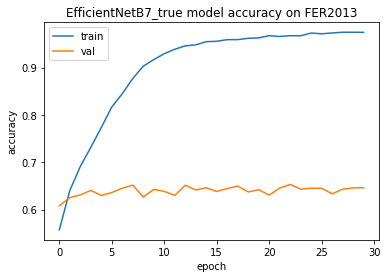

In [35]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('EfficientNetB7_true model accuracy on FER2013')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('EfficientNetB7_true_FER2013_model_accuracy.png')
!cp EfficientNetB7_true_FER2013_model_accuracy.png "/content/drive/MyDrive/Research/"
plt.show()


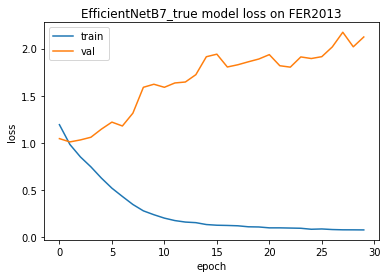

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('EfficientNetB7_true model loss on FER2013')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('EfficientNetB7_true_FER2013_model_loss.png')
!cp EfficientNetB7_true_FER2013_model_loss.png "/content/drive/MyDrive/Research/"
plt.show()

In [31]:
print("Training Accuracy ",max(history.history['accuracy']))
print("Testing Accuracy",max(history.history['val_accuracy']))


Training Accuracy  0.9745814204216003
Testing Accuracy 0.6531223058700562


In [34]:
#Save the Model 
model.save("EfficientNetB7_true_FER2013")
!cp -r EfficientNetB7_true_FER2013 "/content/drive/MyDrive/Research/"
import tensorflow as tf

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model("EfficientNetB7_true_FER2013") # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model in the .tflite .
with open('EfficientNetB7_true_FER2013.tflite', 'wb') as f:
  f.write(tflite_model)

# copy the .tflite to Drive
!cp EfficientNetB7_true_FER2013.tflite "/content/drive/MyDrive/Research/"

ConverterError: ignored